<h1 style="font-size:40px;">Measuring the Impact of COVID-19 Traffic Restrictions on Seismic Activity in Cities</h1>

## 1. Importing Libaries

Installing ObsPy, a python library used to retreive raw seismic data from a range of data sources, Including IRIS and Raspberry-Shake. It also has many functions that can help us process this raw data. We also use numpy and Pandas to handle the data, and Matplotlib to plot/visualize our results


In [1]:
# To install Obspy Run this code snippet
!pip install obspy

In [2]:
#Standard Libraries
import datetime
import os
import csv
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

#Data Handling
import numpy as np
import pandas as pd

#Obspy is a Python libary to help download and process seismic data
from obspy import UTCDateTime, read
from obspy.clients.fdsn import Client
from obspy.signal import PPSD

## 2. Defining Station Information

First, we need to retreive the raw data from the Seismic Monitoring Station of our choice, in this case, in Toronto. To do this, we first need to define information on that station (Network, Station, Location, Channel). We also need to state from what range of time do we need to retreive the data for.

In [5]:
#Here we define range of time we would like to download data for. 
start = UTCDateTime("2019-12-15")  
end = UTCDateTime("2020-6-12")

#This is the information on the seismic monitoring station we would like to download data from
network = "WU"
station = "TORO" # For this example we will use data from a station in Toronto, Canada.
location = "--"
channel = "HHZ"

# Data provider is the source where we are getting data. You can replace this with any valid data provider
# Such as "RaspiShake". You will need to change the above information accordingly.
data_provider = "IRIS" # IRIS -> Incorporated Research Institutions for Seismology (Iris.Edu)

datelist = pd.date_range(start.datetime, end.datetime, freq="D")
c = Client(data_provider)

## 3. Downloading Raw Data from Station in [Mini-Seed] format
#### Mini-seed files contain seismic waveform data. It is an alternative to regular Seed files, which contain much more Meta-Data which will not be used here

Warning : Downloading the mini-seed files for a 6 month period may take from 2 - 6 hours. To perform analysis on a smaller time period, please change the *start* and *end*. A suggest alternative could be : 

start = UTCDateTime("2019-2-20) | 
end = UTCDateTime("2020-6-1")

For this example, I have pre-downloaded all the required data, which you can find at _______. Running this notebook inside that folder will shorten the time of the next command to about 5 minutes

In [6]:
# We will seperately download mini-seed files for each day in the selected range.
for day in datelist:
    fn = day.strftime(station + "-%Y-%m-%d.mseed")
    print(fn)
    if day != datelist[-1] and os.path.isfile(fn):
        continue
    else:
        st = c.get_waveforms(network, station, location, channel, UTCDateTime(day)-1801, UTCDateTime(day)+86400+1801, attach_response=True)
        
        st = st.resample(100) # Resampling all data to 100 Hz, --> 100 readings per second
        
        # Continously merging data from each day into 1 main data stream
        st.merge(method=0, fill_value='latest')
        
        print(st)
        
        st.write(fn)
        
        
resp = c.get_stations(UTCDateTime(day), network=network, station=station, location=location, channel=channel, level="response")
print(resp)

TORO-2019-12-15.mseed
TORO-2019-12-16.mseed
TORO-2019-12-17.mseed
TORO-2019-12-18.mseed
TORO-2019-12-19.mseed
TORO-2019-12-20.mseed
TORO-2019-12-21.mseed
TORO-2019-12-22.mseed
TORO-2019-12-23.mseed
TORO-2019-12-24.mseed
TORO-2019-12-25.mseed
TORO-2019-12-26.mseed
TORO-2019-12-27.mseed
TORO-2019-12-28.mseed
TORO-2019-12-29.mseed
TORO-2019-12-30.mseed
TORO-2019-12-31.mseed
TORO-2020-01-01.mseed
TORO-2020-01-02.mseed
TORO-2020-01-03.mseed
TORO-2020-01-04.mseed
TORO-2020-01-05.mseed
TORO-2020-01-06.mseed
TORO-2020-01-07.mseed
TORO-2020-01-08.mseed
TORO-2020-01-09.mseed
TORO-2020-01-10.mseed
TORO-2020-01-11.mseed
TORO-2020-01-12.mseed
TORO-2020-01-13.mseed
TORO-2020-01-14.mseed
TORO-2020-01-15.mseed
TORO-2020-01-16.mseed
TORO-2020-01-17.mseed
TORO-2020-01-18.mseed
TORO-2020-01-19.mseed
TORO-2020-01-20.mseed
TORO-2020-01-21.mseed
TORO-2020-01-22.mseed
TORO-2020-01-23.mseed
TORO-2020-01-24.mseed
TORO-2020-01-25.mseed
TORO-2020-01-26.mseed
TORO-2020-01-27.mseed
TORO-2020-01-28.mseed
TORO-2020-

C:\Users\Vikas\Anaconda3\lib\site-packages\obspy\io\mseed\core.py:790: UserWarning: The encoding specified in trace.stats.mseed.encoding does not match the dtype of the data.
A suitable encoding will be chosen.
  warnings.warn(msg, UserWarning)


Inventory created at 2020-06-16T18:17:01.000000Z
	Created by: IRIS WEB SERVICE: fdsnws-station | version: 1.1.45
		    http://service.iris.edu/fdsnws/station/1/query?starttime=2020-06-12...
	Sending institution: IRIS-DMC (IRIS-DMC)
	Contains:
		Networks (1):
			WU
		Stations (1):
			WU.TORO (Toronto, Leslie Street Spit, Ontario, Canada)
		Channels (1):
			WU.TORO..HHZ


# **Analysing the Data** :

--------------------------------------------------------------------

## 1. Extracting Probabilistic Power Spectral Densities from Raw Data

In [7]:
for day in datelist:
    fn_in = day.strftime(station + "-%Y-%m-%d.mseed")
    fn_out = day.strftime(station + "-%Y-%m-%d.npz")
    if day != datelist[-1] and os.path.isfile(fn_out):
        continue
    else:    
        st = read(fn_in)
        st.attach_response(resp)
        print(st)
        ppsd = PPSD(st[0].stats, metadata=resp,
                    ppsd_length=1800, overlap=0.5,
                    period_smoothing_width_octaves=0.025,
                    period_step_octaves=0.0125,
                    period_limits=(0.008, 50),
                    db_bins=(-200, 20, 0.25))
        ppsd.add(st)
        ppsd.save_npz(fn_out[:-4])
        del st, ppsd

    
    
for day in datelist:
    fn = day.strftime(station + "-%Y-%m-%d.npz")
    if day == datelist[0]:
        ppsd = PPSD.load_npz(fn)
    else:
        ppsd.add_npz(fn)

1 Trace(s) in Stream:
WU.TORO..HHZ | 2020-06-11T23:29:59.000000Z - 2020-06-13T00:30:01.000000Z | 100.0 Hz, 9000201 samples


C:\Users\Vikas\Anaconda3\lib\site-packages\obspy\signal\spectral_estimation.py:998: RuntimeWarning: Mean of empty slice.
  smoothed_psd.append(specs.mean())
C:\Users\Vikas\Anaconda3\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\Vikas\Anaconda3\lib\site-packages\obspy\signal\spectral_estimation.py:1539: UserWarning: 3/99 segments omitted in file 'TORO-2019-12-16.npz' (time ranges already covered).
  warnings.warn(msg)
C:\Users\Vikas\Anaconda3\lib\site-packages\obspy\signal\spectral_estimation.py:1539: UserWarning: 3/99 segments omitted in file 'TORO-2019-12-17.npz' (time ranges already covered).
  warnings.warn(msg)
C:\Users\Vikas\Anaconda3\lib\site-packages\obspy\signal\spectral_estimation.py:1539: UserWarning: 3/99 segments omitted in file 'TORO-2019-12-18.npz' (time ranges already covered).
  warnings.warn(msg)
C:\Users\Vikas\Anaconda3\lib\site-packages\obspy\signal\spectral_estim

C:\Users\Vikas\Anaconda3\lib\site-packages\obspy\signal\spectral_estimation.py:1539: UserWarning: 3/99 segments omitted in file 'TORO-2020-02-03.npz' (time ranges already covered).
  warnings.warn(msg)
C:\Users\Vikas\Anaconda3\lib\site-packages\obspy\signal\spectral_estimation.py:1539: UserWarning: 3/99 segments omitted in file 'TORO-2020-02-04.npz' (time ranges already covered).
  warnings.warn(msg)
C:\Users\Vikas\Anaconda3\lib\site-packages\obspy\signal\spectral_estimation.py:1539: UserWarning: 3/99 segments omitted in file 'TORO-2020-02-05.npz' (time ranges already covered).
  warnings.warn(msg)
C:\Users\Vikas\Anaconda3\lib\site-packages\obspy\signal\spectral_estimation.py:1539: UserWarning: 3/99 segments omitted in file 'TORO-2020-02-06.npz' (time ranges already covered).
  warnings.warn(msg)
C:\Users\Vikas\Anaconda3\lib\site-packages\obspy\signal\spectral_estimation.py:1539: UserWarning: 3/99 segments omitted in file 'TORO-2020-02-07.npz' (time ranges already covered).
  warnings.

C:\Users\Vikas\Anaconda3\lib\site-packages\obspy\signal\spectral_estimation.py:1539: UserWarning: 3/99 segments omitted in file 'TORO-2020-03-24.npz' (time ranges already covered).
  warnings.warn(msg)
C:\Users\Vikas\Anaconda3\lib\site-packages\obspy\signal\spectral_estimation.py:1539: UserWarning: 3/99 segments omitted in file 'TORO-2020-03-25.npz' (time ranges already covered).
  warnings.warn(msg)
C:\Users\Vikas\Anaconda3\lib\site-packages\obspy\signal\spectral_estimation.py:1539: UserWarning: 3/99 segments omitted in file 'TORO-2020-03-26.npz' (time ranges already covered).
  warnings.warn(msg)
C:\Users\Vikas\Anaconda3\lib\site-packages\obspy\signal\spectral_estimation.py:1539: UserWarning: 3/99 segments omitted in file 'TORO-2020-03-27.npz' (time ranges already covered).
  warnings.warn(msg)
C:\Users\Vikas\Anaconda3\lib\site-packages\obspy\signal\spectral_estimation.py:1539: UserWarning: 3/99 segments omitted in file 'TORO-2020-03-28.npz' (time ranges already covered).
  warnings.

C:\Users\Vikas\Anaconda3\lib\site-packages\obspy\signal\spectral_estimation.py:1539: UserWarning: 3/99 segments omitted in file 'TORO-2020-05-11.npz' (time ranges already covered).
  warnings.warn(msg)
C:\Users\Vikas\Anaconda3\lib\site-packages\obspy\signal\spectral_estimation.py:1539: UserWarning: 3/99 segments omitted in file 'TORO-2020-05-12.npz' (time ranges already covered).
  warnings.warn(msg)
C:\Users\Vikas\Anaconda3\lib\site-packages\obspy\signal\spectral_estimation.py:1539: UserWarning: 3/99 segments omitted in file 'TORO-2020-05-13.npz' (time ranges already covered).
  warnings.warn(msg)
C:\Users\Vikas\Anaconda3\lib\site-packages\obspy\signal\spectral_estimation.py:1539: UserWarning: 3/99 segments omitted in file 'TORO-2020-05-14.npz' (time ranges already covered).
  warnings.warn(msg)
C:\Users\Vikas\Anaconda3\lib\site-packages\obspy\signal\spectral_estimation.py:1539: UserWarning: 3/99 segments omitted in file 'TORO-2020-05-15.npz' (time ranges already covered).
  warnings.

## 2. Proccesing PPSD data to find seismic activity time-series data

In [8]:
# Calulating Root Mean Square
def rms(s, f):
    return np.sqrt(np.trapz(s, f))

In [29]:
# Define frequency bands of interest:
freqs = [(0.1,1.0),(1.0,20.0),(4.0,14.0),(4.0,20.0), (2.0,14.0)]

In [30]:
# Calculating Seismic Displacement over time for different frequency ranges
per = ppsd.period_bin_centers
displacement_RMS = []
for psd in ppsd.psd_values:
    RMS = {}
    for fmin, fmax in freqs:
        ix = np.where((per>=1.0/fmax) & (per<=1.0/fmin))

        # acceleration power spectrum in Hz
        spec = psd.copy()[ix][::-1]
        f = 1.0/per.copy()[ix][::-1]

        # remove NaNs from the list
        valid = np.where(np.isfinite(spec))[0]
        spec = spec[valid]
        f = f[valid]

        w2f = (2.0 * np.pi * f)
        
        # The acceleration amplitude spectrum (dB to Power! = divide by 10 and not 20!)
        amp = 10.0**(spec/10.) 
        
        # velocity spectrum (divide by omega**2)
        vamp = amp / w2f**2
         
        # displacement spectrum (divide by omega**2)
        damp =  vamp / w2f**2

        RMS["%.1f-%.1f"%(fmin, fmax)] = rms(damp, f)

    displacement_RMS.append(RMS)
    
index = pd.DatetimeIndex([d.datetime for d in ppsd.times_processed])
displacement_RMS = pd.DataFrame(displacement_RMS, index=index)

## 3. Visualizing the Seismic Displacement

In [156]:
band = "4.0-20.0"

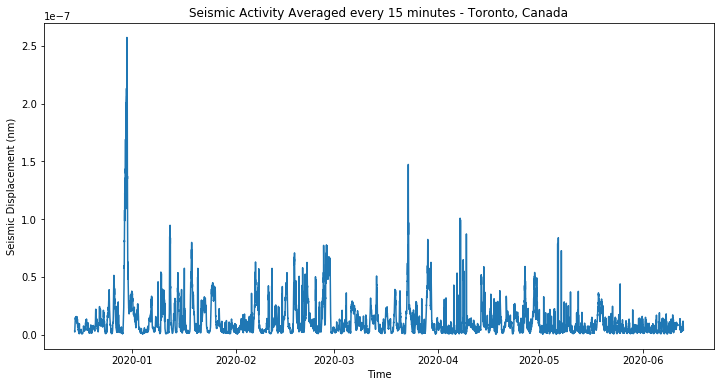

In [157]:
fig = plt.figure(figsize=(12,6))
d = displacement_RMS[band]
plt.title('Seismic Activity Averaged every 15 minutes - Toronto, Canada')
plt.ylabel('Seismic Displacement (nm)')
plt.xlabel('Time')
plt.plot(d.index, d)


In the graph above, you can start to notice a slight trend. But, as there are so many datapoints being plotted, there are too many fluctuations to draw any conclusions. So, we will try resampling our data into 24 hours periods (1 data point per day). We will also create and run a function on the data to remove larger peaks in the data

In [158]:
def remove_peaks(data):
    new = [data[0]]
    COUNT = 0
    for i in data[1:]:
        if i > (new[-1]*6):
            new.append(new[-1])
        else:
            new.append(i)
    return new

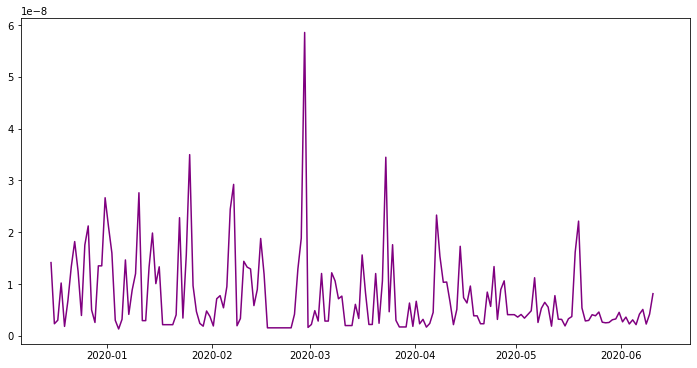

In [159]:
fig = plt.figure(figsize=(12,6))
rs = d.copy().between_time("6:00", "16:00")
rs = rs.resample("1D" ).mean().tshift(12, "H")

ty = rs.index
rs2 = remove_peaks(list(rs))
plt.plot(ty, rs2, label="$\overline{x}$ (6h-16h)", c='purple')

Now, we can actually start to see a trend in our data. The height of the fluctuations are lower towards the end. But to extract proper conclusions from this data, we are going to break it down even further. We will lump these readings into 2-week time periods.

In [160]:
#Calculates Average of a list
def Average(lst):
    return sum(lst) / len(lst)

#splits a list into n number of parts
def chunks(l, n):
    nl = []
    """Yield n number of sequential chunks from l."""
    d, r = divmod(len(l), n)
    for i in range(n):
        si = (d+1)*(i if i < r else r) + d*(0 if i < r else i - r)
        nl.append( l[si:si+(d+1 if i < r else d)])
    return nl
             

In [204]:
c = chunks(rs2, round(len(rs2)/14))

trendline = []

for i in c:
    nc = []
    for ii in i:
        if ii == ii:
            nc.append(ii)
    
    trendline.append(Average(nc))

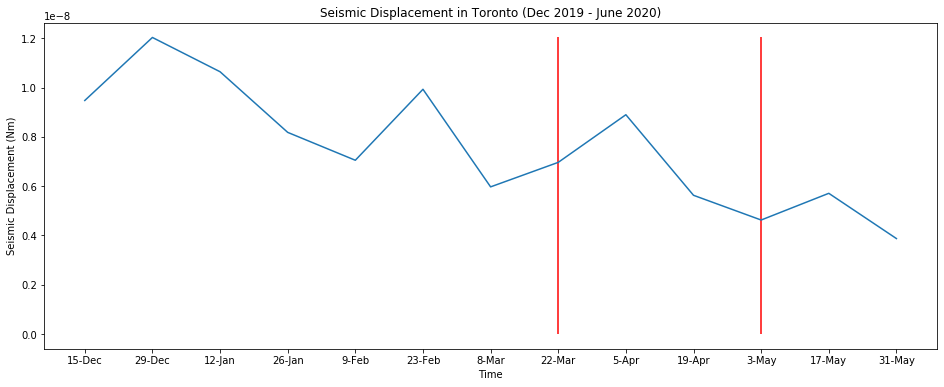

In [205]:
fig = plt.figure(figsize=(16,6))
dates = ['15-Dec','29-Dec','12-Jan','26-Jan','9-Feb','23-Feb','8-Mar','22-Mar','5-Apr','19-Apr','3-May','17-May','31-May']
plt.title('Seismic Displacement in Toronto (Dec 2019 - June 2020)')
plt.xlabel('Time')
plt.ylabel('Seismic Displacement (Nm)')
plt.plot(dates, trendline)

plt.vlines(7, ymin=0, ymax = max(trendline), color='r')
plt.vlines(10, ymin=0, ymax = max(trendline), color='r')

### We can see a significant decrease in seismic activity between the lockdown period, but before calculating exactly how big was this change, let's create a function to create the same plot above for a range of frequencies bands

In [208]:
def plot_displacement(band):
    freqs = [band]
    # Calculating Seismic Displacement over time for different frequency ranges
    per = ppsd.period_bin_centers
    displacement_RMS = []
    for psd in ppsd.psd_values:
        RMS = {}
        for fmin, fmax in freqs:
            ix = np.where((per>=1.0/fmax) & (per<=1.0/fmin))
            # acceleration power spectrum in Hz
            spec = psd.copy()[ix][::-1]
            f = 1.0/per.copy()[ix][::-1]
            # remove NaNs from the list
            valid = np.where(np.isfinite(spec))[0]
            spec = spec[valid]
            f = f[valid]
            w2f = (2.0 * np.pi * f)
            # The acceleration amplitude spectrum (dB to Power! = divide by 10 and not 20!)
            amp = 10.0**(spec/10.) 
            # velocity spectrum (divide by omega**2)
            vamp = amp / w2f**2
            # displacement spectrum (divide by omega**2)
            damp =  vamp / w2f**2
            RMS["%.1f-%.1f"%(fmin, fmax)] = rms(damp, f)
        displacement_RMS.append(RMS)
    index = pd.DatetimeIndex([d.datetime for d in ppsd.times_processed])
    displacement_RMS = pd.DataFrame(displacement_RMS, index=index)
    
    d = displacement_RMS[str(float(band[0])) + '-'+str(float(band[1]))]
    
    fig = plt.figure(figsize=(12,6))
    plt.title('Seismic Activity Averaged every 15 minutes - Toronto, Canada')
    plt.ylabel('Seismic Displacement (nm)')
    plt.xlabel('Time')
    
    rs = d.copy().between_time("6:00", "16:00")
    rs = rs.resample("1D" ).mean().tshift(12, "H")
    ty = rs.index
    rs2 = remove_peaks(list(rs))
    plt.plot(ty, rs2, label="$\overline{x}$ (6h-16h)", c='purple')
    plt.show()
    
    
    c = chunks(rs2, round(len(rs2)/14))
    trendline = []
    for i in c:
        nc = []
        for ii in i:
             if ii == ii:
                nc.append(ii)
        trendline.append(Average(nc))
        
    fig = plt.figure(figsize=(16,6))
    dates = ['15-Dec','29-Dec','12-Jan','26-Jan','9-Feb','23-Feb','8-Mar','22-Mar','5-Apr','19-Apr','3-May','17-May','31-May']
    plt.title('Seismic Displacement in Toronto (Dec 2019 - June 2020)')
    plt.xlabel('Time')
    plt.ylabel('Seismic Displacement (Nm)')
    plt.plot(dates,trendline)

    plt.vlines(7, ymin=0, ymax = max(trendline), color='r')
    plt.vlines(10, ymin=0, ymax = max(trendline), color='r')
    plt.show()
    
    
    
    return trendline

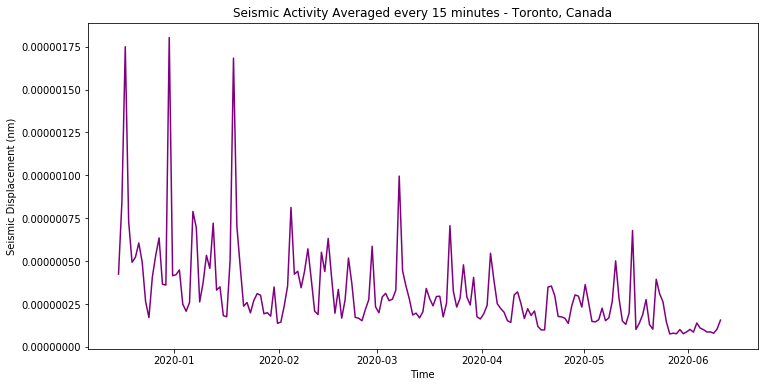

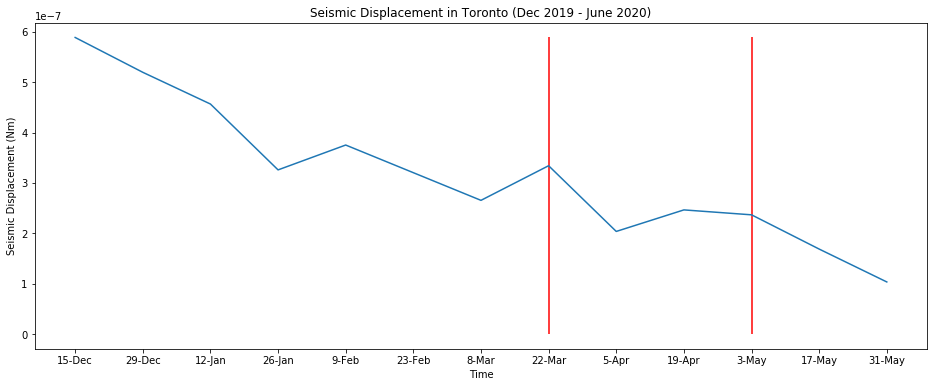

[5.889096086411098e-07,
 5.197175864269246e-07,
 4.567106520673872e-07,
 3.2590073934474835e-07,
 3.752732541383309e-07,
 3.203435059990548e-07,
 2.6540301695188257e-07,
 3.341624851576802e-07,
 2.0366187643445714e-07,
 2.4642758134370006e-07,
 2.3665468559280757e-07,
 1.6864583400871636e-07,
 1.0333537482589454e-07]

In [210]:
# Running this function for frequency range 0.1 to 2
plot_displacement((0.1,2))

### Lets also add a function that can tell us the percentage decrease in seismic activity during this lockdown. To do this, we can simply compare average seismic activity before lockdown, with the average during the lockdown. We will then add this funtion to our previous funtion to work for all frequency inputs

In [224]:
def determine_lockdown_decrease(time_series, dates):
    before_lockdown = Average(time_series[:dates.index('22-Mar')])
    during_lockdown = Average(time_series[dates.index('22-Mar'):dates.index('17-May')])
    
    return (before_lockdown-during_lockdown)/before_lockdown*100

In [244]:
def plot_displacement(band, plot_graph = True):
    freqs = [band]
    # Calculating Seismic Displacement over time for different frequency ranges
    per = ppsd.period_bin_centers
    displacement_RMS = []
    for psd in ppsd.psd_values:
        RMS = {}
        for fmin, fmax in freqs:
            ix = np.where((per>=1.0/fmax) & (per<=1.0/fmin))
            # acceleration power spectrum in Hz
            spec = psd.copy()[ix][::-1]
            f = 1.0/per.copy()[ix][::-1]
            # remove NaNs from the list
            valid = np.where(np.isfinite(spec))[0]
            spec = spec[valid]
            f = f[valid]
            w2f = (2.0 * np.pi * f)
            # The acceleration amplitude spectrum (dB to Power! = divide by 10 and not 20!)
            amp = 10.0**(spec/10.) 
            # velocity spectrum (divide by omega**2)
            vamp = amp / w2f**2
            # displacement spectrum (divide by omega**2)
            damp =  vamp / w2f**2
            RMS["%.1f-%.1f"%(fmin, fmax)] = rms(damp, f)
        displacement_RMS.append(RMS)
    index = pd.DatetimeIndex([d.datetime for d in ppsd.times_processed])
    displacement_RMS = pd.DataFrame(displacement_RMS, index=index)
    
    d = displacement_RMS[str(float(band[0])) + '-'+str(float(band[1]))]
    
    
    rs = d.copy().between_time("6:00", "16:00")
    rs = rs.resample("1D" ).mean().tshift(12, "H")
    ty = rs.index
    rs2 = remove_peaks(list(rs))
    
    
    c = chunks(rs2, round(len(rs2)/14))
    trendline = []
    for i in c:
        nc = []
        for ii in i:
             if ii == ii:
                nc.append(ii)
        trendline.append(Average(nc))
    
    dates = ['15-Dec','29-Dec','12-Jan','26-Jan','9-Feb','23-Feb','8-Mar','22-Mar','5-Apr','19-Apr','3-May','17-May','31-May']
    if plot_graph ==True:
        fig = plt.figure(figsize=(12,4))
        plt.title('Seismic Displacement in Toronto (Dec 2019 - June 2020)')
        plt.xlabel('Time')
        plt.ylabel('Seismic Displacement (Nm)')
        plt.plot(dates,trendline)

        plt.vlines(7, ymin=0, ymax = max(trendline), color='r')
        plt.vlines(10, ymin=0, ymax = max(trendline), color='r')
        plt.show()
    
    decrease = round(determine_lockdown_decrease(trendline,dates), 2)
    
    print('During COVID-19 Lockdown, there was a ' + str(decrease) +'% decrease in seismic activity in the frequency range :  ' + str(float(band[0])) + '-'+str(float(band[1])))
    return decrease

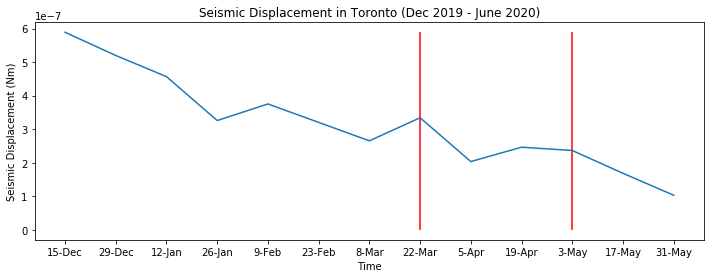

During COVID-19 Lockdown, there was a 37.36% decrease in seismic activity in the frequency range :  0.1-2.0


37.36

In [245]:
# Running this function for frequency range 0.1 to 2
plot_displacement((0.1,2))

Great! Now with a quick run of a function, we can determine the decrease in seismic activty for any range of frequencies! Lets experiment, and plot the change in seismic activity during lockdown for mutliple frequence range, to find out in what frequency range is their the largest decrease

In [264]:
freq_ranges = [(0.1, 3), (3,6), (6,9), (9,12), (12,15), (15,18), (18,21), (21,24), (24,27), (27,30)]

freq_decreases = [] # We will store percentage decrease for each frequency range here
freq_labels = [] # Along the way we will also create labels for each frequency range and store here

for i in freq_ranges:
    freq_decreases.append(plot_displacement(i, plot_graph = False))
    freq_labels.append((str(float(i[0])) + ' - '+str(float(i[1]))))
    

During COVID-19 Lockdown, there was a 37.22% decrease in seismic activity in the frequency range :  0.1-3.0
During COVID-19 Lockdown, there was a 40.62% decrease in seismic activity in the frequency range :  3.0-6.0
During COVID-19 Lockdown, there was a 30.89% decrease in seismic activity in the frequency range :  6.0-9.0
During COVID-19 Lockdown, there was a 34.66% decrease in seismic activity in the frequency range :  9.0-12.0
During COVID-19 Lockdown, there was a 22.36% decrease in seismic activity in the frequency range :  12.0-15.0
During COVID-19 Lockdown, there was a 23.67% decrease in seismic activity in the frequency range :  15.0-18.0
During COVID-19 Lockdown, there was a 33.89% decrease in seismic activity in the frequency range :  18.0-21.0
During COVID-19 Lockdown, there was a 24.84% decrease in seismic activity in the frequency range :  21.0-24.0
During COVID-19 Lockdown, there was a 26.78% decrease in seismic activity in the frequency range :  24.0-27.0
During COVID-19 L

Text(0.5, 1.0, 'Change in seismic Displacement for different Frequency Ranges')

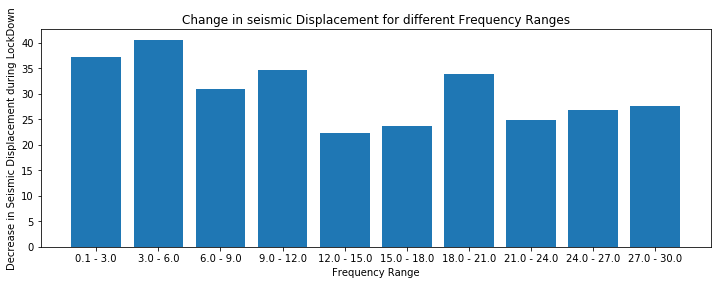

In [267]:
fig = plt.figure(figsize=(12,4))
plt.bar(freq_labels, freq_decreases)
plt.xlabel('Frequency Range')
plt.ylabel('Decrease in Seismic Displacement during LockDown')
plt.title('Change in seismic Displacement for different Frequency Ranges')

So, we can see that the maximum change in seismic vibrations happens in the 3 - 6 range, but all of them are mostly simmilar. If were to view this change across a large frequency range, like 0.1 - 30, we would end up with a 37% change:

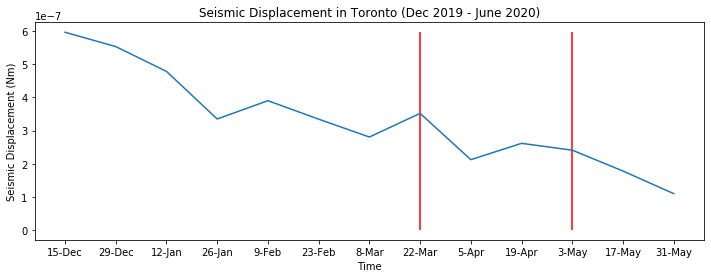

During COVID-19 Lockdown, there was a 37.16% decrease in seismic activity in the frequency range :  0.1-30.0


37.16

In [268]:
plot_displacement((0.1,30))

## Applying this to other cities

This same process can be applied to any IRIS stations in the world. 

The only 3 parameters you need to know about a station is : network, station, and channel. The location parameter is always "--". 

To find these parameters for your local IRIS station, first visit https://www.iris.edu/app/station_monitor/

Then, enter your city into the search bar, and select the prefered station:


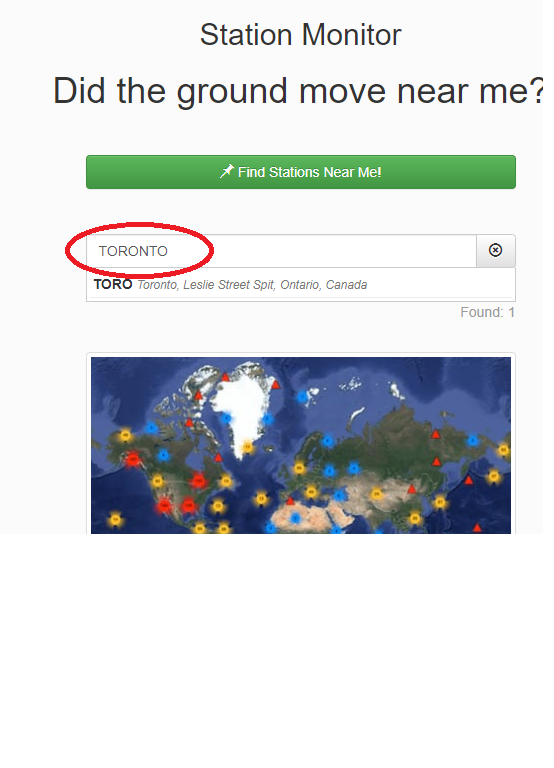

The website should then load live data from that station. 

At the top of the page, you should see a title indicating information about the station.

You should something that looks like TORO_WU in that sentence.

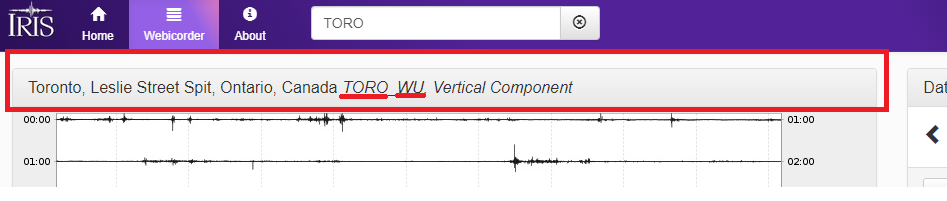

The word before the "_" is the Station Name, in this case : "TORO"

The 2 letters after that represent the network name, which here is "WU"

Finally, to find the channel, scroll down to the bottom right section of the page. There will be a box called Advanced Features. In the bottom part of that box, there should be text showing something simmilar to:

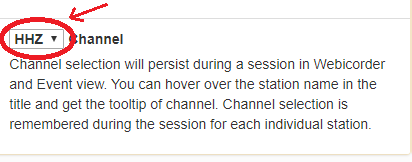

The box where the arrow is pointing is the channel name, which here is "HHZ"

Once you have all 3 parameters, you are good to go! To run this notebook with data from that city, replace the 3 variables in "STATION INFORMATION", Channel, Location, and Network with the new paraters you found. 